# Covid Analysis II
### Mar 2021
* Instructor: Arnab Bose
* Author(s): Nimo Man, Beca Wang, Linqi Yang

## Exploratory Data Analysis

In [1]:
# places data
import pandas as pd
places = pd.read_csv('data/places.csv', index_col=0)
places["geo.bbox"] = places["geo.bbox"].replace('\[','',regex=True).replace('\]','',regex=True)
geo_split = places["geo.bbox"].str.split(', ', n=1, expand=True) 
places['lon'] = geo_split[[0]]
geo_split = geo_split[1].str.split(', ', n=1, expand=True) 
places['lat'] = geo_split[[0]]

import folium
from folium.plugins import FastMarkerCluster
places_map = places.copy().dropna()
map_USA = folium.Map()
lats = places_map['lat'].tolist()
lons = places_map['lon'].tolist()
FastMarkerCluster(data=list(zip(lats, lons))).add_to(map_USA)
# map_USA

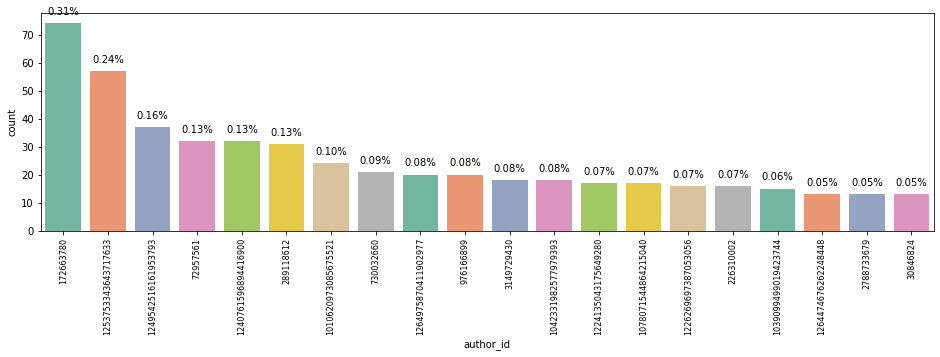

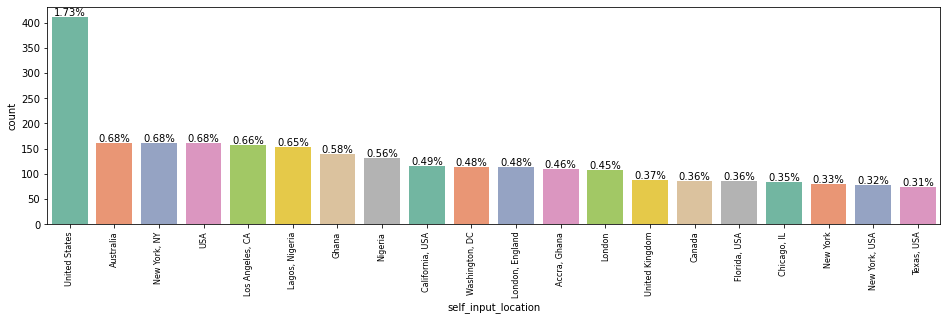

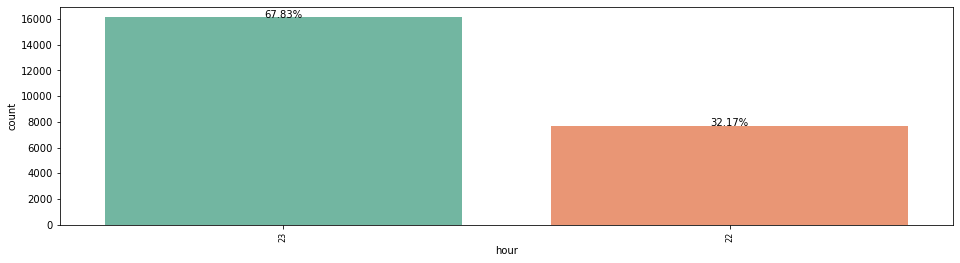

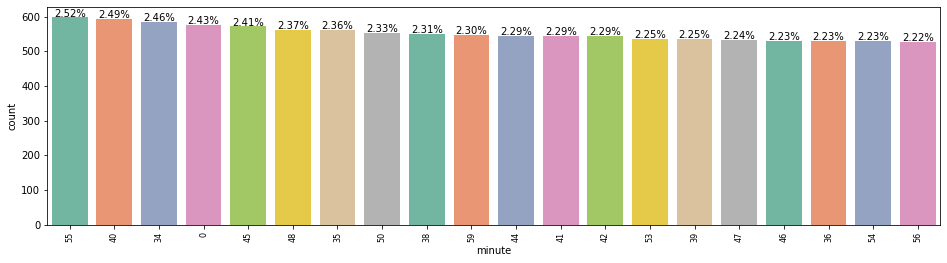

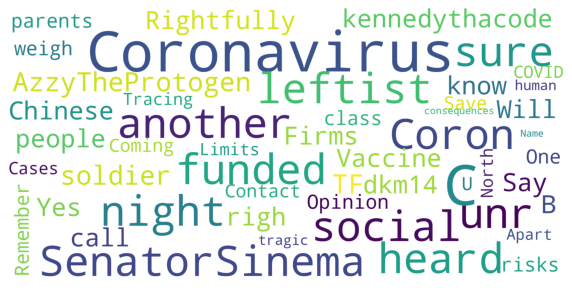

In [2]:
# users data
users = pd.read_csv('data/users.csv', index_col=0)[['id', 'location','username']]
users = users.rename(columns={"id": "author_id", "location": "self_input_location"}, errors="raise")

# text data
text = pd.read_csv('data/text.csv', index_col=0)[['id','author_id','created_at','lang','text']]
text = text.rename(columns={"id": "tweet_id", "lang": "language"})

# join users & text data
df = text.merge(users,on='author_id', how='left')
df = df.drop_duplicates(subset=["text"])
df['created_at'] = pd.to_datetime(df['created_at'])
df['hour'] = df['created_at'].dt.hour
df['minute'] = df['created_at'].dt.minute

import matplotlib.pyplot as plt
import seaborn as sns
def plot_count(feature, df):
    f, ax = plt.subplots(1,1, figsize=(16,4))
    total = float(len(df))
    g = sns.countplot(df[feature], order = df[feature].value_counts().index[:20], palette='Set2')
    plt.xticks(rotation=90, size=8)
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(100*height/total),
                ha="center") 
    plt.show() 
for i in ['author_id', 'self_input_location', 'hour', 'minute']:plot_count(i, df)
    
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
def show_wordcloud(data):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=set(STOPWORDS),
        max_words=50,
        max_font_size=40, 
        scale=5,
        random_state=1
    ).generate(str(data))
    fig = plt.figure(1, figsize=(10,10))
    plt.axis('off')
    plt.imshow(wordcloud)
    plt.show()
show_wordcloud(df['text'])

## Topic Modeling

In [11]:
tweets = pd.read_csv('data/text.csv', index_col=0)['text'].drop_duplicates().str.lower()
tweets_before = tweets.copy()
tweets_before.head()

0    for another night of leftist funded social unr...
1    @senatorsinema not sure if you heard but coron...
2    @azzytheprotogen not only was he soldier in tf...
3    @kennedythacode rightfully? you call that righ...
4    @dkm14 yes. i know 4 people who have had it an...
Name: text, dtype: object

In [12]:
# popular hashtags
import re
def find_hashtags(tweet): return re.findall('(#[A-Za-z]+[A-Za-z0-9-_]+)', tweet)
hashtags = tweets.apply(find_hashtags)
pd.Series([k for j in hashtags[hashtags.apply(lambda i: i != [])] for k in j]).value_counts().head()

#covid19             2232
#coronavirus         1122
#covid                353
#protests2020         250
#blacklivesmatter     173
dtype: int64

In [13]:
# clean tweets
def remove_hashtags(tweet):
    tweet = re.sub('# [\w]*', '', tweet)
    tweet = re.sub('#[\w]*', '', tweet)
    return tweet
tweets = tweets.apply(remove_hashtags)

def remove_users(tweet):
    tweet = re.sub('@ [\w]*', '', tweet)
    tweet = re.sub('@[\w]*', '', tweet)
    return tweet
tweets = tweets.apply(remove_users)

def remove_links(tweet):
    tweet = re.sub(r'http\S+', '', tweet)
    tweet = re.sub(r'bit.ly/\S+', '', tweet)
    tweet = tweet.strip('[link]')
    return tweet
tweets = tweets.apply(remove_links)

def remove_words(tweet):
    tweet = re.sub('covid', '', tweet)
    tweet = re.sub('coronavirus', '', tweet)
    tweet = re.sub('corona', '', tweet)
    return tweet
tweets = tweets.apply(remove_words)

tweets = tweets.str.replace('[^a-zA-Z#]', ' ', regex=True)  # remove nonalpha characters

tweets = tweets.apply(lambda x: ' '.join([i for i in x.split() if len(i)>3])) # remove words with length not greater than 3

from nltk.corpus import stopwords
from gensim.utils import simple_preprocess
def remove_stopwords(tweet): return [i for i in simple_preprocess(tweet) if i not in stopwords.words('english')]
tweets = tweets.apply(remove_stopwords)

import numpy as np
tweets[tweets.apply(len) < 3] = np.nan

tweets_after = tweets.apply(lambda x: np.nan if x is np.nan else ' '.join(x))

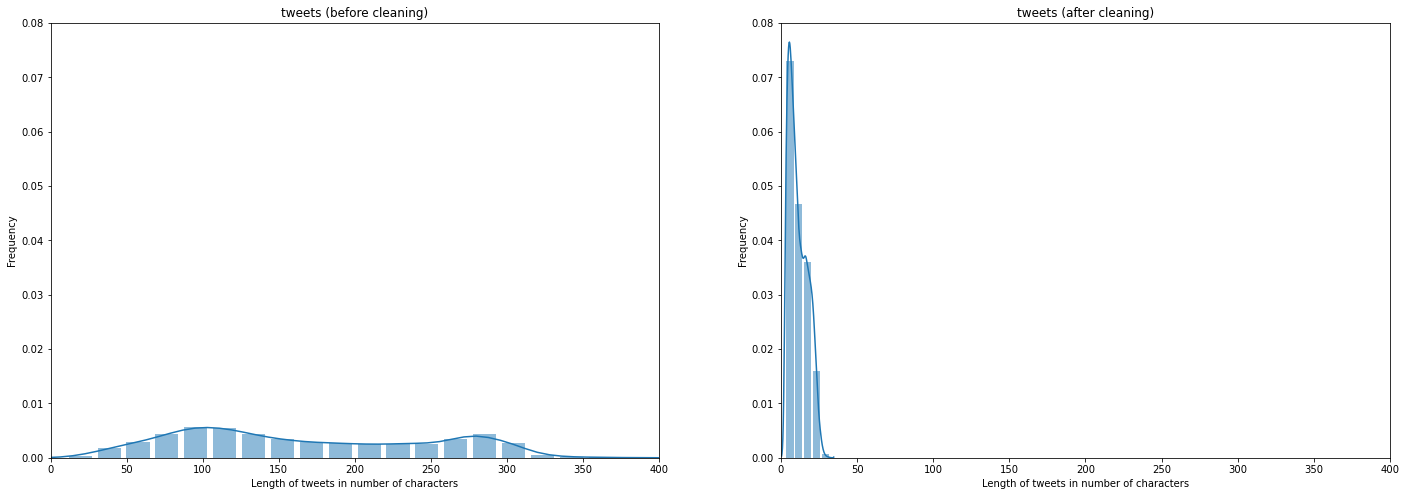

In [14]:
# visualize cleaning effects
plt.figure(figsize=(24, 8))

plt.subplot(1,2,1)
sns.distplot(tweets_before.str.len(), bins = 50, hist_kws={'alpha': 0.5,'rwidth':0.8})
plt.title('tweets (before cleaning)')
plt.xlabel('Length of tweets in number of characters')
plt.ylabel('Frequency')
plt.xlim([0,400])
plt.ylim([0,.08])

plt.subplot(1,2,2)
sns.distplot(tweets.str.len(), bins = 5, hist_kws={'alpha': 0.5,'rwidth':0.8})
plt.title('tweets (after cleaning)')
plt.xlabel('Length of tweets in number of characters')
plt.ylabel('Frequency')
plt.xlim([0,400])
plt.ylim([0,.08]);

In [20]:
# text normalization
import gensim
df = pd.DataFrame({'before cleaning': tweets_before, 'after cleaning': tweets_after, 'tokenization': tweets})
df.dropna(inplace = True)
tweets = df['tokenization']

bi = gensim.models.Phrases(tweets, min_count=10, threshold=100)
bigram_model = gensim.models.phrases.Phraser(bi)
def get_bigram(tweet): return [bigram_model[i] for i in tweet]
bigrams = get_bigram(tweets)

import spacy
def lemmatization(tweet):
    output = []
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    for i in tweet: output.append([token.lemma_ for token in nlp(' '.join(i)) if token.pos_ in ['NOUN', 'ADJ', 'VERB', 'ADV']])
    return output
tweets_lem = lemmatization(bigrams)

from nltk.stem import PorterStemmer
def stemming(tweet):
    output = []
    for i in tweet: output.append([PorterStemmer().stem(j) for j in i])
    return output
tweets_stem = stemming(tweets_lem)

df['lemmatization'] = tweets_lem
df['stemming'] = tweets_stem
df.reset_index(inplace = True)

In [23]:
# latent dirichlet allocation (LDA)
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(max_df=0.9, min_df=25, token_pattern='[a-zA-Z0-9]{3,}', analyzer='word')
vec = vectorizer.fit_transform(df['stemming'].apply(lambda x: ' '.join(x)))

from sklearn.decomposition import LatentDirichletAllocation
model = LatentDirichletAllocation(n_components=3, random_state=0)
model.fit_transform(vec)
print('Log Likelihood: ', model.score(vec)) # higher the better
print('Perplexity: ', model.perplexity(vec)) # lower the better

# dominant topic for each tweet
df['Topic (dominant)'] = np.argmax(np.round(model.transform(vec), 2), axis=1)
df.head()

Log Likelihood:  -1146247.952023732
Perplexity:  851.8392889098902


index                                    before cleaning  \
0      0  for another night of leftist funded social unr...   
1      1  @senatorsinema not sure if you heard but coron...   
2      2  @azzytheprotogen not only was he soldier in tf...   
3      3  @kennedythacode rightfully? you call that righ...   
4      4  @dkm14 yes. i know 4 people who have had it an...   

                                      after cleaning  \
0  another night leftist funded social unrest glo...   
1  sure heard virus officially defeated hundreds ...   
2  soldier also starfox gaming legend death trage...   
3  rightfully call rightful even give hours start...   
4     know people nurses work units real still thing   

                                        tokenization  \
0  [another, night, leftist, funded, social, unre...   
1  [sure, heard, virus, officially, defeated, hun...   
2  [soldier, also, starfox, gaming, legend, death...   
3  [rightfully, call, rightful, even, give, hours...   
4  [know, people, nurses, work, units, real, stil...   

                                       lemmatization  \
0  [night, leftist, fund, social, unrest, globali...   
1  [sure, hear, virus, officially, defeat, hundre...   
2  [soldier, also, starfox, gaming, legend, death...   
3  [rightfully, call, rightful, even, give, hour,...   
4  [know, people, nurse, work, unit, real, still,...   

                                            stemming  Topic (dominant)  
0  [night, leftist, fund, social, unrest, global,...                 0  
1  [sure, hear, viru, offici, defeat, hundr, thou...                 2  
2  [soldier, also, starfox, game, legend, death, ...                 0  
3  [right, call, right, even, give, hour, start, ...                 2  
4  [know, peopl, nurs, work, unit, real, still, t...                 1

In [24]:
# top 10 keywords for each topic
keywords = []
for topic_weights in model.components_: keywords.append(np.array(vectorizer.get_feature_names()).take((-topic_weights).argsort()[:10]))
pd.DataFrame(keywords, columns = ['Word '+str(i) for i in range(10)], index = ['Topic '+str(i) for i in range(3)]).T

Topic 0 Topic 1  Topic 2
Word 0  pandem    come    peopl
Word 1   world    home     case
Word 2    news    time  protest
Word 3  govern    work    death
Word 4   death    stay    black
Word 5    riot    make    trump
Word 6    time    know     viru
Word 7   crisi    test   happen
Word 8    stop    help   number
Word 9     bad    take  countri

## Sentiment Analysis

In [38]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]

import sparknlp
spark = sparknlp.start()
print("Spark NLP version", sparknlp.version())
print("Apache Spark version:", spark.version)
from sparknlp.pretrained import PretrainedPipeline

topic0 = df[df['Topic (dominant)'] == 0]
sentiment_imdb_glove = PretrainedPipeline('analyze_sentimentdl_glove_imdb', lang='en')
topic0['sentiment'] = topic0['after cleaning'].apply(lambda x: sentiment_imdb_glove.annotate(x)['sentiment'])

topic1 = df[df['Topic (dominant)'] == 1]
sentiment_imdb_glove = PretrainedPipeline('analyze_sentimentdl_glove_imdb', lang='en')
topic1['sentiment'] = topic1['after cleaning'].apply(lambda x: sentiment_imdb_glove.annotate(x)['sentiment']) 

topic2 = df[df['Topic (dominant)'] == 2]
sentiment_imdb_glove = PretrainedPipeline('analyze_sentimentdl_glove_imdb', lang='en')
topic2['sentiment'] = topic2['after cleaning'].apply(lambda x: sentiment_imdb_glove.annotate(x)['sentiment'])]

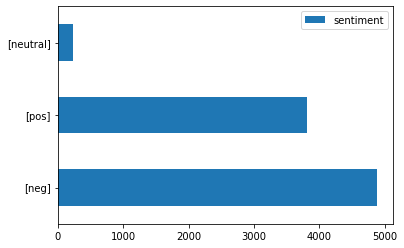

In [129]:
topic0['sentiment'].value_counts().to_frame().plot(kind = 'barh')

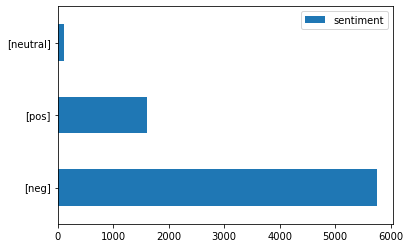

In [130]:
topic1['sentiment'].value_counts().to_frame().plot(kind = 'barh')

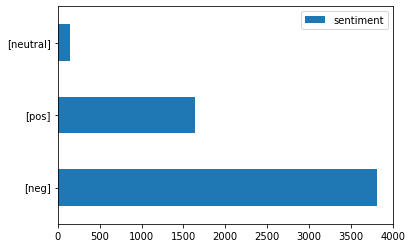

In [131]:
topic2['sentiment'].value_counts().to_frame().plot(kind = 'barh')

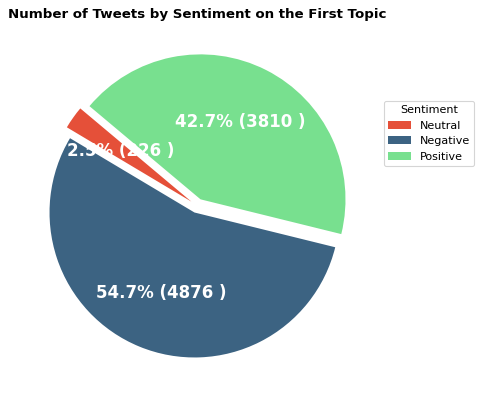

In [70]:
# topic0
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw=dict(aspect="equal"), dpi= 80)

data = [topic0.sentiment.value_counts()[-1], topic0.sentiment.value_counts()[0], topic0.sentiment.value_counts()[1]]
categories = ['Neutral', 'Negative', 'Positive']
explode = [0.05,0.05,0.05]

def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}% ({:d} )".format(pct, absolute)

wedges, texts, autotexts = ax.pie(data, 
                                  autopct=lambda pct: func(pct, data),
                                  textprops=dict(color="w"), 
                                  colors=['#e55039', '#3c6382', '#78e08f'],
                                  startangle=140,
                                  ee)

# Decoration
ax.legend(wedges, categories, title="Sentiment", loc="center left", bbox_to_anchor=(1, 0.2, 0.5, 1))
plt.setp(autotexts, size=15, weight=700)
ax.set_title("Number of Tweets by Sentiment on the First Topic", fontsize=12, fontweight="bold")
plt.show()

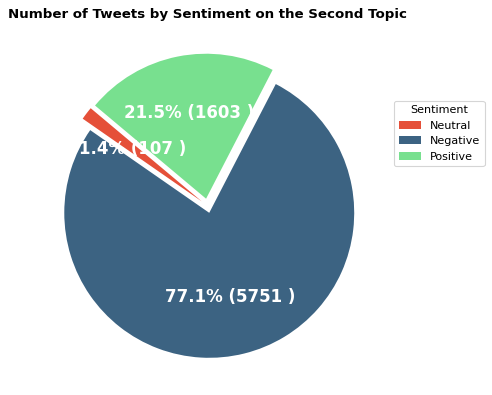

In [75]:
# topic1
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw=dict(aspect="equal"), dpi= 80)

data = [topic1.sentiment.value_counts()[-1], topic1.sentiment.value_counts()[0], topic1.sentiment.value_counts()[1]]
categories = ['Neutral', 'Negative', 'Positive']
explode = [0.05,0.05,0.05]

def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}% ({:d} )".format(pct, absolute)

wedges, texts, autotexts = ax.pie(data, 
                                  autopct=lambda pct: func(pct, data),
                                  textprops=dict(color="w"), 
                                  colors=['#e55039', '#3c6382', '#78e08f'],
                                  startangle=140,
                                  ee)

# Decoration
ax.legend(wedges, categories, title="Sentiment", loc="center left", bbox_to_anchor=(1, 0.2, 0.5, 1))
plt.setp(autotexts, size=15, weight=700)
ax.set_title("Number of Tweets by Sentiment on the Second Topic", fontsize=12, fontweight="bold")
plt.show()

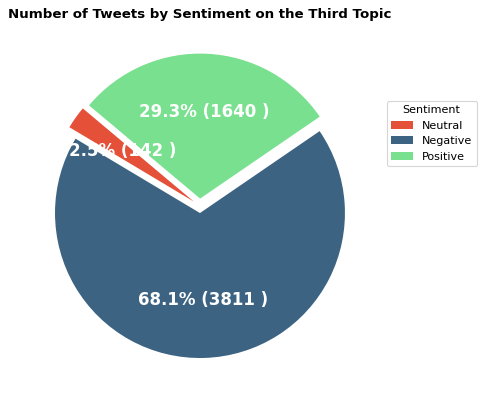

In [76]:
# topic2
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw=dict(aspect="equal"), dpi= 80)

data = [topic2.sentiment.value_counts()[-1], topic2.sentiment.value_counts()[0], topic2.sentiment.value_counts()[1]]
categories = ['Neutral', 'Negative', 'Positive']
explode = [0.05,0.05,0.05]

def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}% ({:d} )".format(pct, absolute)

wedges, texts, autotexts = ax.pie(data, 
                                  autopct=lambda pct: func(pct, data),
                                  textprops=dict(color="w"), 
                                  colors=['#e55039', '#3c6382', '#78e08f'],
                                  startangle=140,
                                  explode=explode)

# Decoration
ax.legend(wedges, categories, title="Sentiment", loc="center left", bbox_to_anchor=(1, 0.2, 0.5, 1))
plt.setp(autotexts, size=15, weight=700)
ax.set_title("Number of Tweets by Sentiment on the Third Topic", fontsize=12, fontweight="bold")
plt.show()

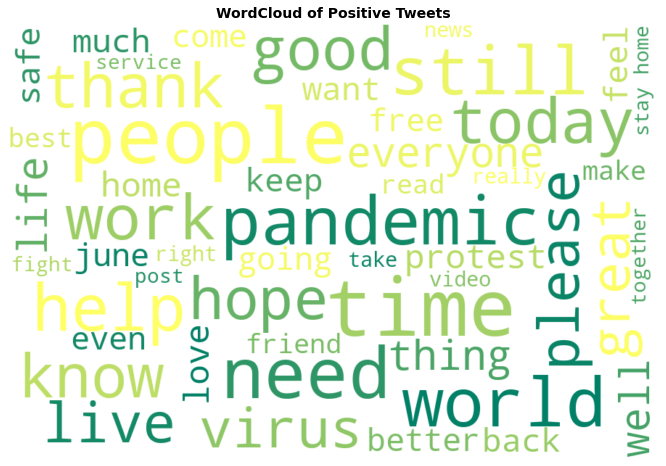

In [126]:
# topic0
df0_pos = df0[df0['sentiment'] == "'pos'"]
df0_neg = df0[df0['sentiment'] == "'neg'"]
all_words0_pos = ' '.join([text for text in df0_pos['after cleaning']])
all_words0_neg = ' '.join([text for text in df0_neg['after cleaning']])

wordcloud = WordCloud(width=900, height=600, random_state=21, max_font_size=110, background_color='white', 
                      max_words=50,colormap='summer').generate(all_words0_pos)

plt.figure(figsize=(12, 8))
plt.title('WordCloud of Positive Tweets', fontsize=14, fontweight="bold")
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

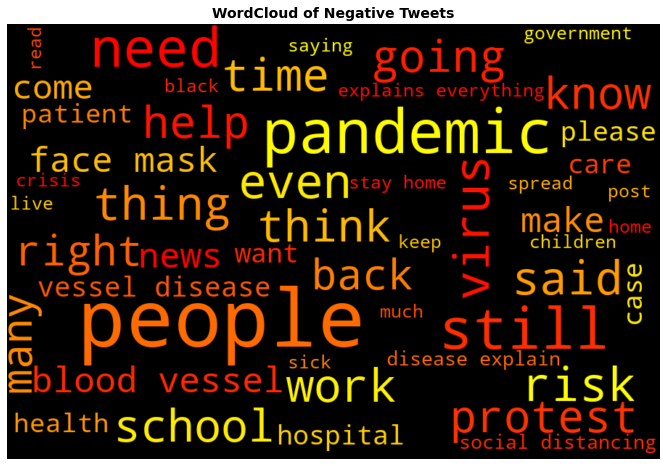

In [127]:
wordcloud = WordCloud(width=900, height=600, random_state=21, max_font_size=110, background_color='black', 
                      max_words=50,colormap='autumn').generate(all_words0_neg)

plt.figure(figsize=(12, 8))
plt.title('WordCloud of Negative Tweets', fontsize=14, fontweight="bold")
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

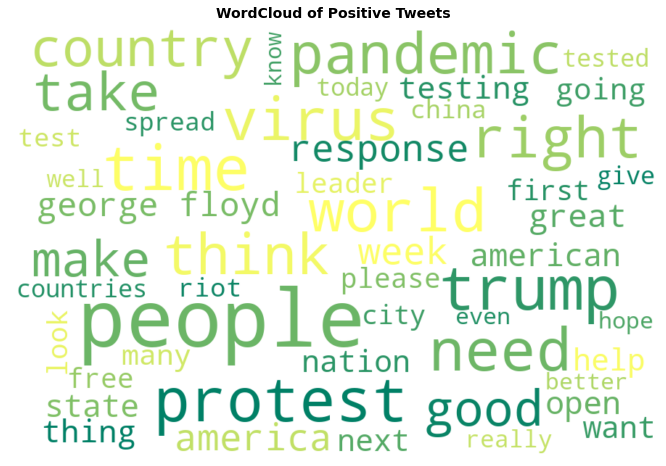

In [116]:
# topic1
df1_pos = df1[df1['sentiment'] == "'pos'"]
df1_neg = df1[df1['sentiment'] == "'neg'"]
all_words1_pos = ' '.join([text for text in df1_pos['after cleaning']])
all_words1_neg = ' '.join([text for text in df1_neg['after cleaning']])

wordcloud = WordCloud(width=900, height=600, random_state=21, max_font_size=110, background_color='white', 
                      max_words=50,colormap='summer').generate(all_words1_pos)

plt.figure(figsize=(12, 8))
plt.title('WordCloud of Positive Tweets', fontsize=14, fontweight="bold")
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

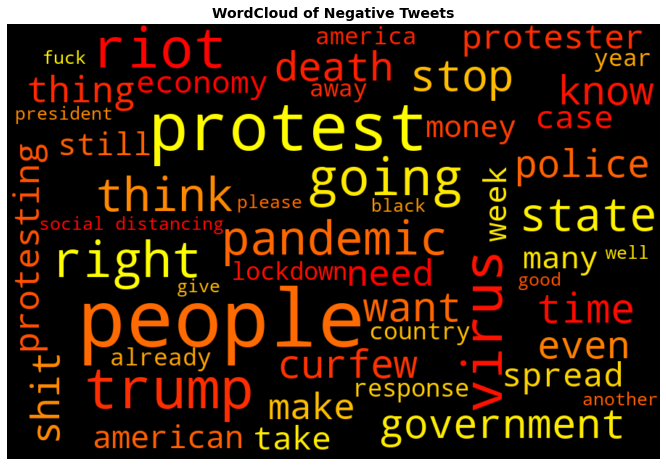

In [117]:
wordcloud = WordCloud(width=900, height=600, random_state=21, max_font_size=110, background_color='black', 
                      max_words=50,colormap='autumn').generate(all_words1_neg)

plt.figure(figsize=(12, 8))
plt.title('WordCloud of Negative Tweets', fontsize=14, fontweight="bold")
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

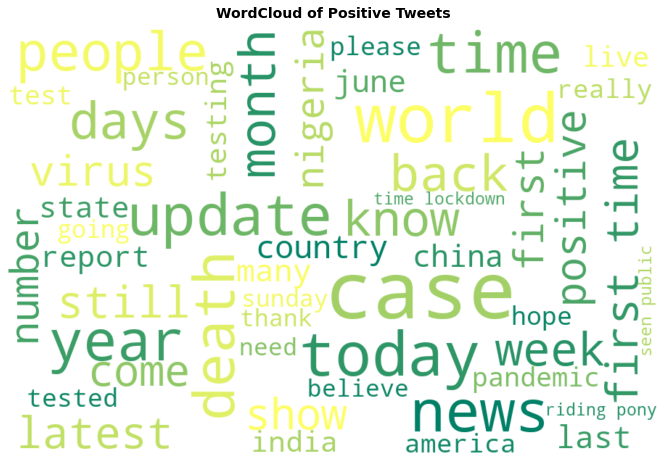

In [119]:
# topic2
df2_pos = df2[df2['sentiment'] == "'pos'"]
df2_neg = df2[df2['sentiment'] == "'neg'"]
all_words2_pos = ' '.join([text for text in df2_pos['after cleaning']])
all_words2_neg = ' '.join([text for text in df2_neg['after cleaning']])

wordcloud = WordCloud(width=900, height=600, random_state=21, max_font_size=110, background_color='white', 
                      max_words=50,colormap='summer').generate(all_words2_pos)

plt.figure(figsize=(12, 8))
plt.title('WordCloud of Positive Tweets', fontsize=14, fontweight="bold")
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

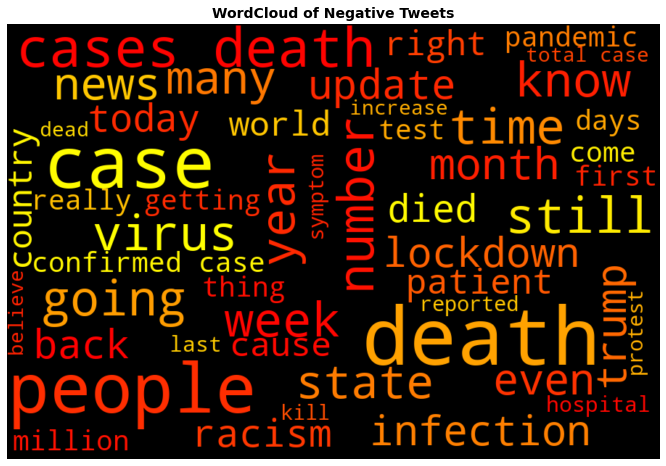

In [120]:
wordcloud = WordCloud(width=900, height=600, random_state=21, max_font_size=110, background_color='black', 
                      max_words=50,colormap='autumn').generate(all_words2_neg)

plt.figure(figsize=(12, 8))
plt.title('WordCloud of Negative Tweets', fontsize=14, fontweight="bold")
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()